In [23]:
import tensorflow as tf

# univariate cnn example
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import Sequence
from keras.utils import to_categorical

In [24]:
df = pd.read_csv('data.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [25]:
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

In [26]:
print(X.shape)
print(y.shape)

(989642, 39)
(989642,)


In [ ]:
from sklearn.model_selection import train_test_split

#Data splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) 
print(X_val.shape)
print(X_train.shape)

In [28]:
from keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(X_train, y_train, length=40, sampling_rate=1, batch_size=40)
val_generator = TimeseriesGenerator(X_val, y_val, length=40, sampling_rate=1, batch_size=40)

In [45]:
df_test = pd.read_csv('test_data.csv')
df_test.drop(columns=df.columns[0], axis=1, inplace=True)

X_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:, -1].values
print(X_test.shape)
print(y_test.shape)

test_generator = TimeseriesGenerator(X_test, y_test, length=40, sampling_rate=1, batch_size=40)

(754000, 39)
(754000,)


In [29]:
X_tune = np.empty(shape=(17318, 40, 39))
y_tune = np.empty(shape=(17318))
for items in train_generator.__iter__():
   u, v = items
   np.concatenate((X_tune, u))
   np.concatenate((y_tune, v))

In [30]:
from keras.optimizers import Adam
from keras.activations import softmax, sigmoid
from keras.regularizers import L1L2

def model_builder(hp):

    lr_min, lr_max = 1e-3, 1e-1

    lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(2, activation=softmax))

    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    return model

In [41]:
# Hyperparameter optimisation
import keras_tuner as kt

tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=10,
                     directory='./Tuning',
                     project_name='sepsis_hyperparam',
                     overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_tune, y_tune, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 00m 33s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 04m 59s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [42]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.012158303534721207.



In [43]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
from keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint(filepath='FirstPredictor', monitor='accuracy', verbose=1, save_best_only=True, mode='min')
callbacks=[checkpoint]

model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=10, verbose=1, callbacks=callbacks, validation_data=val_generator)


Epoch 1/10


2023-01-14 17:11:43.314448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17317/17318 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.9106

2023-01-14 17:14:37.569820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from inf to 0.91062, saving model to FirstPredictor


INFO:tensorflow:Assets written to: FirstPredictor/assets


INFO:tensorflow:Assets written to: FirstPredictor/assets


17318/17318 [==============================] - 209s 12ms/step - loss: 0.5000 - accuracy: 0.9106 - val_loss: 0.5000 - val_accuracy: 0.9105
Epoch 2/10
17316/17318 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.9107
Epoch 2: accuracy did not improve from 0.91062
17318/17318 [==============================] - 192s 11ms/step - loss: 0.5000 - accuracy: 0.9107 - val_loss: 0.5000 - val_accuracy: 0.9105
Epoch 3/10
17316/17318 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.9107
Epoch 3: accuracy did not improve from 0.91062
17318/17318 [==============================] - 190s 11ms/step - loss: 0.5000 - accuracy: 0.9107 - val_loss: 0.5000 - val_accuracy: 0.9105
Epoch 4/10
17313/17318 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.9107
Epoch 4: accuracy did not improve from 0.91062
17318/17318 [==============================] - 189s 11ms/step - loss: 0.5000 - accuracy: 0.9107 - val_loss: 0.5000 - val_accuracy: 0.9105
Epoch 5

In [59]:
model.save('SepsisPredictor3.h5', save_format='h5')

## Evaluating the ouput of the network

In [46]:
eval_result = model.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

18849/18849 [==============================] - 108s 6ms/step - loss: 0.5000 - accuracy: 0.9761
[test loss, test accuracy]: [0.5, 0.9761273860931396]


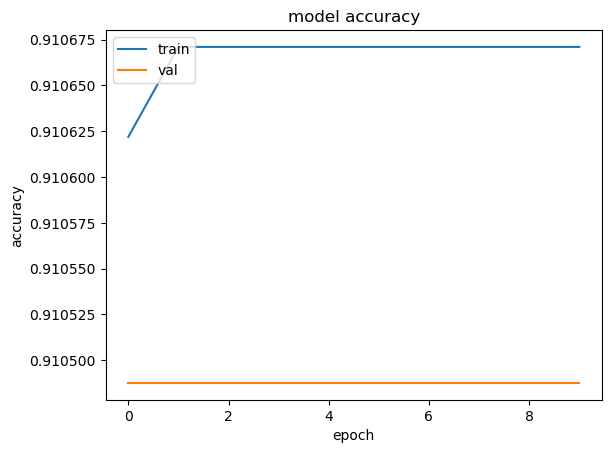

In [65]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./plots/model_acc.png')

In [52]:
reconstructed_model = tf.keras.models.load_model('SepsisPredictor3')

In [55]:
yhat = reconstructed_model.predict(test_generator[0][0])

1/2 [==============>...............] - ETA: 0s

2023-01-14 17:58:28.473439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 66ms/step


In [56]:
print(yhat)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
